**Full Name: Ahmed Abdalgadir Mohammed Turkman**

The library I used here is **Pytorch**

We need first to import the libraries used in the solution

# Preparing the Data:

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, BatchSampler
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import defaultdict
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here, I unzipped the date file and extracted it into a folder named: "data".


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/AIMS/Computer_Vision/Assignments/A3/VeRi.zip -d data

Now I need to create a custom dataset creates a mapping between every image and its label.

In [ ]:
class VeRiDataset(Dataset):
  def __init__(self, img_dir):
    self.img_dir = img_dir
    self.img_filenames = os.listdir(img_dir)

  def __len__(self):
    return len(self.img_filenames)

  def __getitem__(self, idx):
    filename = self.img_filenames[idx]
    img_path = os.path.join(self.img_dir, filename)
    image = cv2.imread(img_path)
    # Doing some transformation to the image, so that it fits the model I will use.
    image = cv2.resize(image, (224, 224))
    image = torch.tensor(np.array(image))
    image = image / 255.0
    image = torch.permute(image, (2, 0, 1))
    label = int(filename[:4])
    return image, label

In [ ]:
train_img_dir = '/content/data/VeRi/image_train'
train_set = VeRiDataset(train_img_dir)

The next step is creating a custom batch sampler. I used this batch sampler to ensure that every batch has P labels and K images per label, making the batch size equal to P*K. In my model, I used P = 12, and K = 4.

In [ ]:
class CustomBatchSampler(BatchSampler):
  def __init__(self, dataset, P=10, K=4):

    self.dataset = dataset
    self.P = P
    self.K = K

    self.class_indices = self._get_class_indices()
    self.order = self._get_order()

  def _get_class_indices(self):
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(self.dataset):
      class_indices[label].append(idx)
    return class_indices

  def _get_order(self):
    order = []
    labels = set(self.class_indices.keys())
    count = {label: len(self.class_indices[label]) for label in self.class_indices.keys()}

    while len(labels) >= self.P:
      sampled_labels = random.sample(labels, self.P)
      for label in sampled_labels:

        order.append(label)
        count[label] -= self.K

        if count[label] < self.K:
          labels.remove(label)

    order.reverse()
    return order


  def __iter__(self):
    for key in self.class_indices.keys():
      random.shuffle(self.class_indices[key])

    batch = []
    while self.order:
      for _ in range(self.P):
        for _ in range(self.K):
          batch.append(self.class_indices[self.order[-1]].pop())
        self.order.pop()
      yield batch
      batch = []

  def __len__(self):
      return len(self.order) // self.P


In [ ]:
my_sampler = CustomBatchSampler(train_set, 12, 4)

<ipython-input-7-380c53a3036f>:23: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_labels = random.sample(labels, self.P)


In [ ]:
train_loader = DataLoader(train_set, batch_sampler=my_sampler)

# Training the Model:

First, I defined a function for computing the euclidean distance between any two given vectors. This function will be helpful for creating triplets during the online data mining phase later.


In [ ]:
def euc_dist(x, y):
  ans = (x - y) ** 2
  ans = ans.sum().sqrt()
  return ans.item()

Here, I defined my strategy for choosing triplets from a specific batch of images and labels. I used the Batch Sample (BS) method, which involves sampling the positives and negatives according to the distributions of all possible positives and all possible negatives per anchor. In total my function returns a number of triplets equals to the size of the batch.

In [ ]:
def find_triplets(images, labels, margin=1):
  dic = {}
  for i in range(len(labels)):
    if labels[i] in dic:
      dic[labels[i]].append(i)
    else:
      dic[labels[i]] = [i]

  anchors = []
  positives = []
  negatives = []

  for label, indices in dic.items():
    for anch in indices:

      all_pos = [i for i in indices if i != anch]
      dists = [euc_dist(images[anch], images[i]) for i in all_pos]
      dist_sum = sum(dists)
      probabilities = [dist / dist_sum for dist in dists]

      pos = np.random.choice(all_pos, p=probabilities)

      all_neg = []
      for temp_label, temp_indices in dic.items():
        if temp_label == label:
          continue
        all_neg.extend(temp_indices)

      dists = np.array([euc_dist(images[anch], images[i]) for i in all_neg])
      probabilities = np.exp(-dists)
      probabilities /= np.sum(probabilities)

      neg = np.random.choice(all_neg, p=probabilities)

      anchors.append(anch)
      positives.append(pos)
      negatives.append(neg)

  return images[anchors], images[positives], images[negatives]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

Now, everything is ready to start building the model. I used a pretrained model (resnet50) and freezed the features layers and replaced the classifier with two fully connected layers.

In [ ]:
class Embedding_Net(nn.Module):
    def __init__(self, embedding_dim=128):
        super(Embedding_Net, self).__init__()
        self.model = models.resnet50(pretrained=True)
        for params in self.model.parameters():
          params.requires_grad = False
        self.model.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward(self, x):
        return self.model(x)

model = Embedding_Net(embedding_dim=128).to(device)

Starting the training phase:

In [ ]:
import time
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 12
margin = 1
triplet_loss = nn.TripletMarginLoss(margin=1.0, reduction='none')

tic = time.time()
model.train()
for epoch in range(num_epochs):

  my_sampler = CustomBatchSampler(train_set, 12, 4)
  train_loader = DataLoader(train_set, batch_sampler=my_sampler)
  training_loss = 0
  count = 0

  for i, (images, labels) in enumerate(train_loader):
    if i % 100 == 0:
      print('i =', i)
    images, labels = images.to(device), labels.to(device)
    embeddings = model(images)
    anchors, positives, negatives = find_triplets(embeddings, [x.item() for x in labels], margin)

    losses = triplet_loss(anchors, positives, negatives)
    training_loss += losses.sum()
    count += losses.shape[0]
    loss = losses.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  toc = time.time()
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss / count:.3f}")
  print('Total Time:', round((toc - tic) / 60, 2), 'mins')

<ipython-input-7-380c53a3036f>:23: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_labels = random.sample(labels, self.P)


i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [1/12], Loss: 0.621
Total Time: 6.04 mins
i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [2/12], Loss: 0.600
Total Time: 11.88 mins
i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [3/12], Loss: 0.587
Total Time: 17.48 mins
i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [4/12], Loss: 0.570
Total Time: 23.05 mins
i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [5/12], Loss: 0.559
Total Time: 28.67 mins
i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [6/12], Loss: 0.564
Total Time: 34.25 mins
i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [7/12], Loss: 0.549
Total Time: 39.89 mins
i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [8/12], Loss: 0.540
Total Time: 45.5 mins
i = 0
i = 100
i = 200
i = 300
i = 400
i = 500
i = 600
i = 700
Epoch [9/12], Loss: 0.535
Total Time: 51.1 mins
i = 

In [ ]:
# Saving the model
model_path = '/content/drive/MyDrive/AIMS/Computer_Vision/Assignments/A3/trained_model_plus.pth'
torch.save(model, model_path)

In [ ]:
# # Loading the model
# model_path = '/content/drive/MyDrive/AIMS/Computer_Vision/Assignments/A3/trained_model_plus.pth'
# model = torch.load(model_path, map_location=device)

# Evaluation:

First, I defined a function for extracting the features. I used it later to extract the features of both the query and test images.

In [ ]:
def extract_features(model, img_dir):
  model.eval()
  with torch.no_grad():
    embeddings = {}
    filenames = os.listdir(img_dir)
    for i, filename in enumerate(filenames):
      img_path = os.path.join(img_dir, filename)
      img = cv2.imread(img_path)
      img = cv2.resize(img, (224, 224))
      img = torch.tensor(np.array(img)) / 255
      img = img.permute((2, 0, 1)).view(1, 3, 224, 224).to(device)
      emb = model(img)
      embeddings[filename] = emb
      if i % 1000 == 0:
        print(f'[{i}/{len(filenames)}] ....')

  return embeddings

In [ ]:
# Extracting the features for the test images
test_dir = '/content/data/VeRi/image_test'
test_embeds = extract_features(model, test_dir)

[0/11579] ....
[1000/11579] ....
[2000/11579] ....
[3000/11579] ....
[4000/11579] ....
[5000/11579] ....
[6000/11579] ....
[7000/11579] ....
[8000/11579] ....
[9000/11579] ....
[10000/11579] ....
[11000/11579] ....


In [ ]:
test_embeds_path = '/content/drive/MyDrive/AIMS/Computer_Vision/Assignments/A3/test_embeds_plus.pth'
torch.save(test_embeds, test_embeds_path)
# test_embeds = torch.load(test_embeds_path, map_location=device)

In [ ]:
# Extracting the features for the query images
query_dir = '/content/data/VeRi/image_query'
query_embeds = extract_features(model, query_dir)

[0/1678] ....
[1000/1678] ....


In [ ]:
query_embeds_path = '/content/drive/MyDrive/AIMS/Computer_Vision/Assignments/A3/query_embeds_plus.pth'
torch.save(query_embeds, query_embeds_path)
# query_embeds = torch.load(query_embeds_path, map_location=device)

Here, I defined a function for plotting the top K closest images for a given query image:

In [ ]:
def plot_topK(filename, query_dir, test_dir, k=5):
  query_id = int(filename[:4])
  query_embed = query_embeds[filename]
  test_images = os.listdir(test_dir)
  test_images.sort(key = lambda x: euc_dist(query_embed, test_embeds[x]))

  fig, axes = plt.subplots((k) // 5 + 1, 5, figsize=(17, 6))
  query_path = os.path.join(query_dir, filename)
  img = Image.open(query_path)
  axes[0][0].imshow(img)
  axes[0][0].set_title(f'Query Image, ID: {query_id}')
  axes[0][0].axis('off')

  for i in range(k):
      img_path = os.path.join(test_dir, test_images[i])
      img_id = int(test_images[i][:4])
      img = Image.open(img_path)
      i += 1
      axes[i // 5][i % 5].imshow(img)
      axes[i // 5][i % 5].set_title(f'Rank: {i}, ID: {img_id}')
      axes[i // 5][i % 5].axis('off')
  plt.show()

In [ ]:
query_dir = '/content/data/VeRi/image_query'
test_dir = '/content/data/VeRi/image_test'
query_images = os.listdir(query_dir)
test_images = os.listdir(test_dir)

I plotted the closest 9 images for some query images:

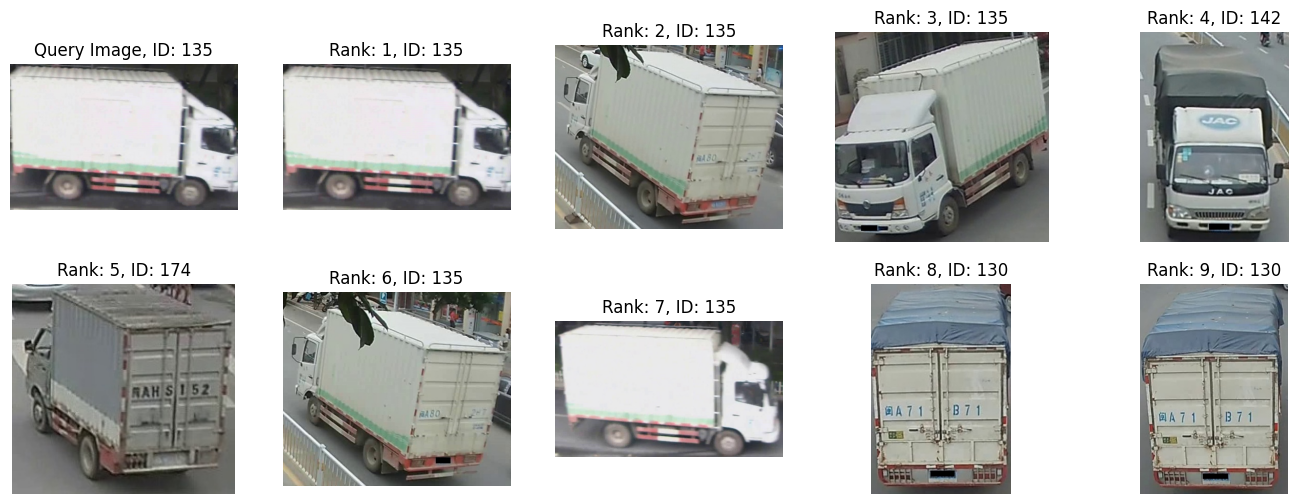

In [ ]:
plot_topK(query_images[random.randrange(len(query_images))], query_dir, test_dir, 9)

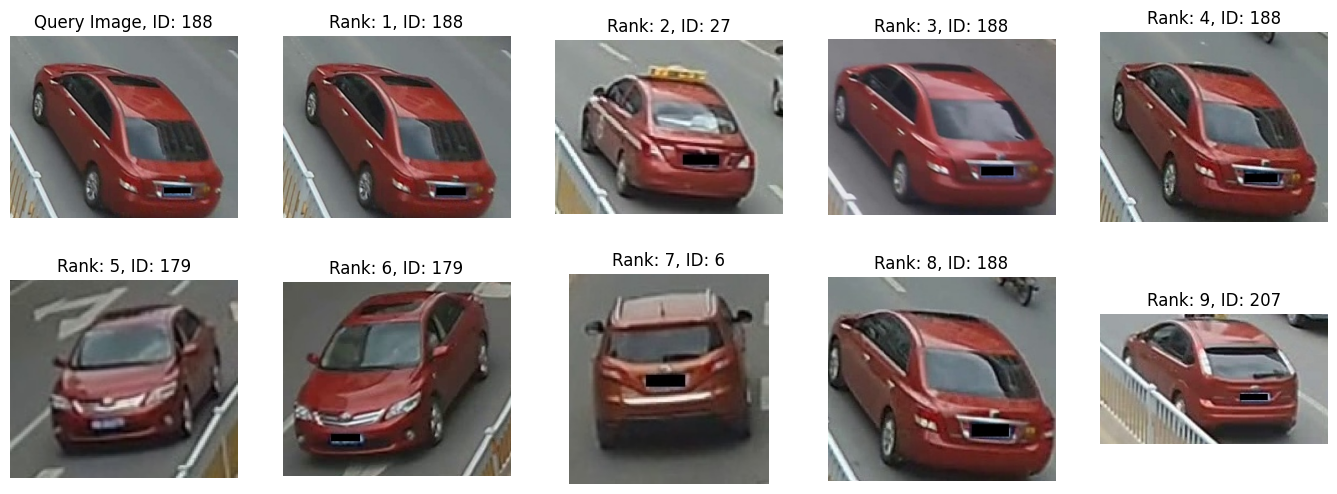

In [ ]:
plot_topK(query_images[random.randrange(len(query_images))], query_dir, test_dir, 9)

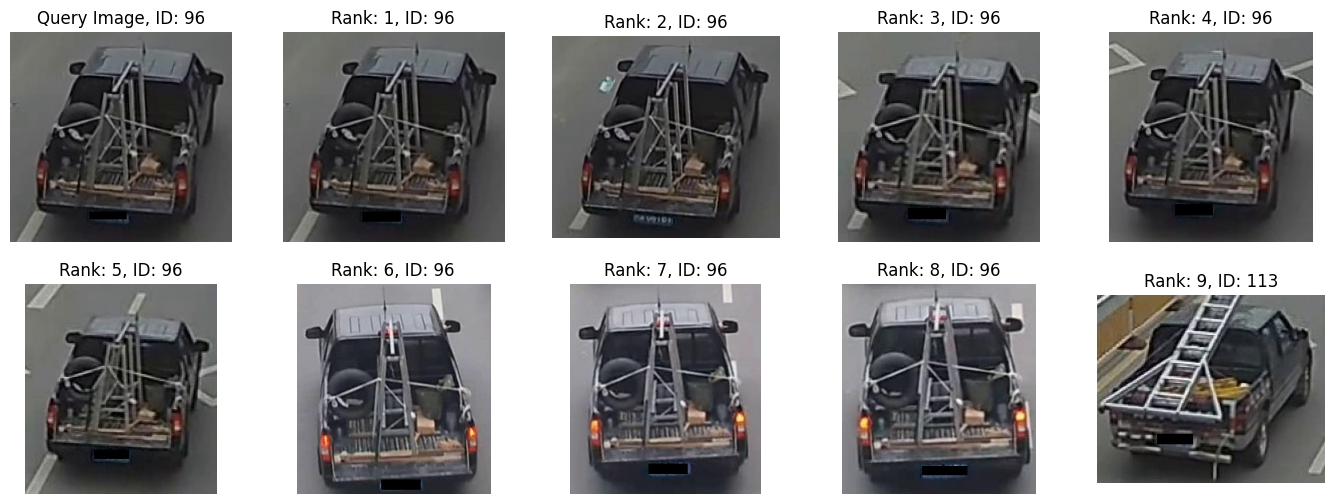

In [ ]:
plot_topK(query_images[random.randrange(len(query_images))], query_dir, test_dir, 9)

In [ ]:
def average_precision(query_filename, test_dir):
  query_id = int(query_filename[:4])
  query_embed = query_embeds[query_filename]
  test_filenames = os.listdir(test_dir)
  test_filenames.sort(key = lambda x: euc_dist(query_embed, test_embeds[x]))

  true_preds = [int(int(name[:4]) == query_id) for name in test_filenames]
  cum_true_preds = true_preds.copy()
  for i in range(1, len(cum_true_preds)):
    cum_true_preds[i] += cum_true_preds[i - 1]

  num_trues = cum_true_preds[-1]

  precision = [cum_true_preds[i] / (i + 1) for i in range(len(cum_true_preds))]

  ap = sum([precision[i] * true_preds[i] for i in range(len(precision))])
  ap /= num_trues


  return ap

In [ ]:
def get_map(query_dir, test_dir):
  query_filenames = os.listdir(query_dir)
  map = 0
  i = 0
  for query_filename in query_filenames:
    map += average_precision(query_filename, test_dir)
    if i % 100 == 0:
      print(f'[{i}/{len(query_filenames)}]', end='\t')
      print(f'map = {map / (i + 1):.4f}')
    i += 1
  map /= len(query_filenames)
  return map


In [ ]:
map = get_map(query_dir, test_dir)
print(f'mAP = {map:.4f}')

[0/1678]	map = 0.2044
[100/1678]	map = 0.2213
[200/1678]	map = 0.2076
[300/1678]	map = 0.1991
[400/1678]	map = 0.2053
[500/1678]	map = 0.2150
[600/1678]	map = 0.2150
[700/1678]	map = 0.2136
[800/1678]	map = 0.2132
[900/1678]	map = 0.2150
[1000/1678]	map = 0.2128
[1100/1678]	map = 0.2105
[1200/1678]	map = 0.2127
[1300/1678]	map = 0.2127
[1400/1678]	map = 0.2130
[1500/1678]	map = 0.2127
[1600/1678]	map = 0.2119
mAP = 0.2115


The Mean Average Precision was finally found to be 21.19%.